In [ ]:
# default_exp train.loop

# TODO:

* train/test/split
* evaluation slips/review
* Progress Bar
* Picle and joblib
* Minio
* Storage + ObjectStoree
* Model metadata
* Treatment type + storage
* Evaluation type + storage
* Subject type + storage
* Full processing loop with storage, versions, search
* changelog/report centrally
* fix documentation/flow (possibly upgrade nbdev)

## Later

* NLP
* automl
* unsupervised
* semi-supervised
* FastAI v2
* manual pipelines
* PySpark pipeline
* Great Expectations
* Kibana
* SQS + Terraform
* cache
* Flask
* Monitoring

# Loop

Training should be done on a loop: subjects and treatments all getting consistent model evaluation with results stored centrally.  Basically, create reproducible results quickly, automate the easy stuff.

Here I gather a few utilities, practices, interfaces, and demonstrations to make this easier for everyone.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import io
import requests

import datetime as dt
from datetime import datetime
import re
from pathlib import Path
import hashlib

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from lab.util.test_functions import *

In [ ]:
#export
def artifact_storage(*a, **kw):
    """Infer how the user intends to store
    artifacts: models, versions, treatments,
    and evaluation results."""

    def noop(subject, treatment, model, result): pass
    return noop

def generic_runner(subject, treatment, *a, **kw):
    """Naive concept. I have something smarter
    running somewhere, but I'm not sure where it is."""
    storage = artifact_storage(*a, **kw)
    model = None
    result = treatment(subject)
    return storage(subject, treatment, model, result)

def runner(*a, **kw):
    """Infer the runner and its artifact storage."""
    return generic_runner

def train_loop(subjects, treatments, *a, **kw):
    """The main training loop."""

    fn = runner(*a, **kw)

    for subject in np.array(subjects):
        for treatment in np.array(treatments):
            fn(subject, treatment, *a, **kw)

In [ ]:
# This is not normal...expecting to use models, fit, predict,
# hyper parameters, etc.

def t(name, n, subject):
    result = round(subject + n, 2)
    print(f"{name}: {result}")
    return result

def t1(subject): return t('t1', 1, subject)
def t2(subject): return t('t2', 2, subject)

subjects = stats.norm.rvs(size=3) + 10
print(subjects)

train_loop(subjects, [t1, t2])

[12.02844088  8.9797755  10.1115382 ]
t1: 13.03
t2: 14.03
t1: 9.98
t2: 10.98
t1: 11.11
t2: 12.11


So far, garbage.

There's a possibility that I'm going this way, but I did that in reverse. So, I started fixing some things by training some models. And, that's giving me something more useful.

The following is still wrong, but better.

The [MD5 stuff](https://docs.python.org/3/library/hashlib.html) is kind of cool, but I always forget a step and have to look it up:

* convert input to a string
* build a hashing object (use hashlib's tools)
* update the hashing object with a utf-8-encoded string
* create a hex digest

In [ ]:
def to_md5(*s):
    s = '|'.join(s)
    m = hashlib.md5()
    m.update(str(s).encode('utf-8'))
    return m.hexdigest()

class ObjectStore:
    """Pass through extract from a set of ordered
    stores, or get the data directly."""
    
    # TODO: replace with configured values
    LOCAL_CACHE = '/tmp'
    
    @classmethod
    def call(cls, url, **kw):
        return cls(**kw)(url)

    def __init__(self, **kw):
        self.kw = kw
        
    @property
    def local_cache(self):
        """Return a path for the directory where data is cached."""
        if hasattr(self, '_local_cache'): return self._local_cache
        self._local_cache = Path(self.kw.get('local_cache', self.LOCAL_CACHE))
        return self._local_cache
    
    @property
    def certs(self):
        if hasattr(self, '_certs'): return self._certs
        self._certs = self.kw.get('certs')
        return self._certs
    
    @property
    def allow_raise(self):
        if hasattr(self, '_allow_raise'): return self._allow_raise
        self._allow_raise = self.kw.get('allow_raise', False)
        return self._allow_raise
    
    @property
    def re_fetch(self):
        """When true, overwrite the local cache from the remote source."""
        if hasattr(self, '_re_fetch'): return self._re_fetch
        self._re_fetch = self.kw.get('re_fetch', False)
        return self._re_fetch
    
    def local_file(self, url):
        """Convert a filename to an MD5 hash and join it
        to the local cache."""
        return self.local_cache / to_md5(url)
    
    def content_from_url(self, url):
        """Use requests to fetch content from a url"""
        kw = {}
        if not self.certs is None: kw['certs'] = self.certs
        try:
            s = requests.get(url, **kw).content
            return s.decode('utf-8')
        except:
            if self.allow_raise: raise
            return False
        
    def get_local_content(self, url):
        """Read content from the local cache"""
        try:
            if self.re_fetch: return False
            local = self.local_file(url)
            if not local.exists(): return False
            with open(local, 'r') as f:
                return f.read()
        except:
            if self.allow_raise: raise
            return False
        
    def get_remote_content(self, url):
        """Read content from a remote path"""
        try:
            content = self.content_from_url(url)
            local = self.local_file(url)
            with open(local, 'w') as f:
                if hasattr(content, 'decode'):
                    f.write(content.decode('utf-8'))
                else:
                    f.write(content)
            return content
        except:
            if self.allow_raise: raise
            return False
    
    def local_or_remote(self, url):
        """Return a local version of the data
        or get it, save it, and return it."""
        return (
            self.get_local_content(url) or
            self.get_remote_content(url)
        )

    def __call__(self, url):
        return self.local_or_remote(url)
    
class ValuesFromUrl:
    """Convert CSV content into a 2-d NumPy array."""
    
    @classmethod
    def call(cls, url, **kw):
        return cls(**kw)(url)
    
    def __init__(self, **kw):
        self.kw = kw

    def content(self, url):
        """Use ObjectStore to get CSV data."""
        return ObjectStore.call(url, **self.kw)
    
    def values(self, url):
        """Use Pandas to convert CSV to NumPy."""
        content = self.content(url)
        return pd.read_csv(io.StringIO(content)).values
    
    def __call__(self, url):
        return self.values(url)


In [ ]:
subject = ObjectStore()
assert ObjectStore(local_cache='local').local_cache == Path('local')
assert subject.local_cache == Path(ObjectStore.LOCAL_CACHE)
assert ObjectStore(certs='certs').certs == 'certs'
root = subject.local_cache
expected = root/to_md5('foo')
assert subject.local_file('foo') == expected

invalid_url = 'http://invalid.example.com/some_file'
assert not subject.content_from_url(invalid_url)
with check_raises(message="Can permit raises with `allow_raise=True`."):
    ObjectStore(allow_raise=True).content_from_url(invalid_url)
assert not ObjectStore(re_fetch=True, allow_raise=True).get_local_content(invalid_url)

The ObjectStore can get data remotely, with certs. If it does that, it will store it locally. If the content is already stored locally, it returns that instead.

In [ ]:
def content_from_url(url, **kw):
    """Get the content from the ObjectStore"""
    return ObjectStore.call(url, **kw)

def dataframe_from_url(url, **kw):
    """Create a Pandas DataFrame from content."""
    content = ObjectStore.call(**kw)
    return pd.read_csv(io.StringIO(content))

def values_from_url(url, **kw):
    """Get the NumPy array from url"""
    return ValuesFromUrl.call(url, **kw)

In [ ]:
def white_list(keywords, keys, require_keys=False):
    """Filter a dictionary by a set of keys"""
    if require_keys:
        return {key:keywords[key] for key in keys}
    return {key:keywords.get(key) for key in keys}

def k_fold(**kw):
    """Use scikit-learn's KFold with some control
    on reasonable defaults."""
    defaults = {'n_splits': 10}
    kw = {**defaults, **kw}
    return model_selection.KFold(**kw)

def process_model(name, model, X, Y, storage={}, scoring='accuracy', **kw):
    """Process a model using K-Fold cross validation."""
    kfold = k_fold()
    result = model_selection.cross_val_score(
        model, X, Y,
        cv=kfold, scoring=scoring
    )
    store(name, result, storage=storage)

def store(name, result, storage={}):
    """Simple storage of treatment results."""
    storage[name] = result

def plot_results(results, plot=None, title='Algorithm Comparison', **kw):
    """Create a box plot for each treatment in a results dictionary."""
    if plot is None: plot = plt

    fig = plot.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(list(results.values()))
    ax.set_xticklabels(list(results.keys()))
    plot.show()

def cheap_loop(treatments, subjects, display=True, **kw):
    """Create models without hyperparameter fine tuning
    to determine which algorithms show promise on a particular
    dataset"""
    storage = {}
    for (name, model) in treatments:
        for (x, y) in subjects:
            process_model(name, model(), x, y, storage=storage)
    if display: plot_results(storage, **kw)
    return storage

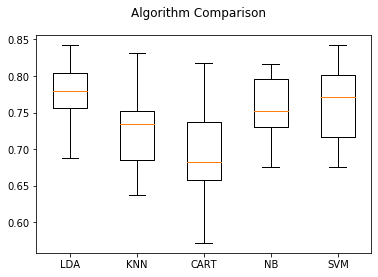

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
array = values_from_url(url, names=names)
X = array[:,0:8]
Y = array[:,8]

treatments = [
#     ('LR', LogisticRegression,
    ('LDA', LinearDiscriminantAnalysis),
    ('KNN', KNeighborsClassifier),
    ('CART', DecisionTreeClassifier),
    ('NB', GaussianNB),
    ('SVM', SVC),
]

subjects = [
    (X, Y)
]

cheap_loop(treatments, subjects);

The cheap_loop is a quick-and-dirty approach to treating data (no hyperparameters are explored).

LogisticRegression is throwing warnings, so I'm just skipping it for now.

Could use some slips, combine some other work I've done, approach different scoring, quite a few other things.

In [ ]:
cv = k_fold()

Understinding the interface with a bunch of training.

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, cv=cv)

{'fit_time': array([0.00302601, 0.00173497, 0.00167012, 0.00139809, 0.00173903,
        0.001436  , 0.00150013, 0.00164413, 0.00149512, 0.00141072]),
 'score_time': array([0.00044608, 0.00035596, 0.00035524, 0.00032306, 0.00037813,
        0.00033116, 0.00036192, 0.00035405, 0.00032997, 0.00031328]),
 'test_score': array([0.7012987 , 0.80519481, 0.75324675, 0.68831169, 0.79220779,
        0.76623377, 0.83116883, 0.84210526, 0.76315789, 0.80263158])}

In [ ]:
cv.__dict__

{'n_splits': 10, 'shuffle': False, 'random_state': None}

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, n_jobs=2)

{'fit_time': array([0.00251389, 0.00251484, 0.00193787, 0.00174499, 0.00153184]),
 'score_time': array([0.00047803, 0.00047898, 0.00037909, 0.00038695, 0.00037003]),
 'test_score': array([0.77272727, 0.73376623, 0.74509804, 0.81045752, 0.77124183])}

The n_jobs determines how many CPUs to use.

Having a wrapper around such a powerful wrapper is weird, but not everything is scikit-learn. So, using a PyTorch example, wrapping with these tools, could be a good justification or a wake up moment that this really is a bad idea (the way I'm abstracting it).

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.00260496, 0.00175476, 0.00209212, 0.00187087, 0.00159526]),
 'score_time': array([0.00068378, 0.00043297, 0.00042701, 0.00041699, 0.00039482]),
 'test_score': array([0.77272727, 0.73376623, 0.74509804, 0.81045752, 0.77124183])}

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s
[CV]  ................................................................
[CV] ................................................. , total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.0026257 , 0.00195503, 0.00225401, 0.00254393, 0.00213003]),
 'score_time': array([0.00045514, 0.00042295, 0.00057507, 0.00043297, 0.00042009]),
 'test_score': array([0.77272727, 0.73376623, 0.74509804, 0.81045752, 0.77124183])}

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, verbose=3)

[CV]  ................................................................
[CV] .................................... , score=0.773, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.734, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.745, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.810, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.771, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'fit_time': array([0.002141  , 0.00188589, 0.00202012, 0.00236964, 0.00209069]),
 'score_time': array([0.00051093, 0.00039077, 0.00040102, 0.00040126, 0.00040007]),
 'test_score': array([0.77272727, 0.73376623, 0.74509804, 0.81045752, 0.77124183])}

OK, so verbosity is kind of cool. The docs didn't show me what I could more easily just check here. I can get information about the concurrency, or see each job visually while it works.

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, return_train_score=True)

{'fit_time': array([0.00171804, 0.00250912, 0.00168514, 0.0018239 , 0.0016768 ]),
 'score_time': array([0.00048113, 0.00055289, 0.00044179, 0.00044107, 0.00042415]),
 'test_score': array([0.77272727, 0.73376623, 0.74509804, 0.81045752, 0.77124183]),
 'train_score': array([0.78303426, 0.76998369, 0.77850163, 0.76872964, 0.78501629])}

In [ ]:
model_selection.cross_validate(LinearDiscriminantAnalysis(), X, Y, return_estimator=True)

{'fit_time': array([0.0019691 , 0.00163603, 0.00172901, 0.00164294, 0.00198793]),
 'score_time': array([0.00043082, 0.00040984, 0.00040197, 0.00039506, 0.00041318]),
 'estimator': (LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001),
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001),
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001),
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001),
  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                             solver='svd', store_covariance=False, tol=0.0001)),
 'test_score': array([0.77272727, 0

So, at this point I've got some comfort around what works, or at least how this works. I'm a little loose on scoring (I should explore and grok that much better).

Working in this way is worth 10 articles. There is no replacement for experimentation.

In [ ]:
model_selection.cross_val_score(LinearDiscriminantAnalysis(), X, Y)

array([0.77272727, 0.73376623, 0.74509804, 0.81045752, 0.77124183])

What's nice about cross_val_score is it has mostly the same interface as cross_validate, but it only returns the scoring. If I'm not going to keep the fit time and score time, then I can just ignore that.

What I'm starting to think is I should normally keep the fit time. I also want a predict time and a develop time. It takes 3 days to build a model, say, and 10 minutes to train it and the resulting model can run in 100 milliseconds. Knowing that, I can spend 5 days building something that trains in 2 hours but returns either better results, or faster results, or some reason to have it.

These are the values needed in the lab and in production. There are always a lot of metrics flying around, and developing confidence with what they mean and what to do needs to be translated into an experiential flow instead of a reflective stall.

--

At this point I'm thinking about abstraction again. What should I use? Do I want kfold?

It's not as important as I made it.

Do I want to go to a pandas dataframe?

Maybe for now, but once I get a better sense of extract X, y, then maybe not so much.

Why didn't you use tools for splitting the data?

I think they had the cross validation, that those needed to be static. It makes assumptions about the data too, that they're independently and randomly distributed in the dataset. If I didn't have that, I should have split the data with tools.

OK, so this is useful:

* abstraction is off, can work better
* grok is off (I'm shooting from the hip)



Notes:

* [emulating containers](https://docs.python.org/3/reference/datamodel.html?emulating-container-types#emulating-container-types)

In [ ]:
#export
def get_matches(r, s):
    """Return all matches, or an empty list."""
    result = re.search(r, s)
    if result is None: return []
    return list(result.groups())

def get_nth_match(r, s, n):
    """Search the string for a regular expression.
    If there is a match, return the nth value(s).
    """
    found = get_matches(r, s)
    try:
        return found[n]
    except IndexError:
        return None

def get_first_match(r, s):
    """Shorthand for get_nth_match."""
    return get_nth_match(r, s, 0)

In [ ]:
r = r'(.+), (.+), and (.+)'
s = "a, b, and c"
assert get_nth_match(r, s, slice(0,2)) == list('ab')

r = r'test_(.+)'
s = 'test_accuracy'
assert get_matches(r, s) == ['accuracy']
assert get_first_match(r, s) == 'accuracy'

r = r'foo_bar'
s = 'No match'
assert get_first_match(r, s) is None

Able to extract keys out of strings, using a regular expression without exposing the internal re quirks.

If I know what I'm doing, I can use a slice.

This comes from a [StackOverflow question](https://stackoverflow.com/questions/15340582/python-extract-pattern-matches).

In [ ]:
class IncrementVersion:
    """Increment a version string.
    There are packages for this (bumpversion) and
    package-management tools, but I thought this
    would be easier than it was."""
    
    DEFAULT_VERSION = '0.0.0'
    LEVELS = ['major', 'minor', 'patch']
    DEFAULT_LEVEL = 'patch'
    ZEROS = [0, 0, 0]
    
    @classmethod
    def call(cls, version, **kw):
        return cls()(version, **kw)
        
    def split_version(self, version):
        try:
            return [int(e) for e in str(version).split('.')]
        except:
            return self.ZEROS
        
    def get_version_parts(self, version):
        """Get a 3-piece version"""
        values = self.split_version(version)[:3]
        values = np.append(values, self.ZEROS)
        return values[:3]
    
    def increment_version(self, version, level='patch', value=None, **kw):
        """Increment the major, minor, or patch.
        Pass in the value, if an explicit value is needed.
        """
        
        if not level in self.LEVELS: level = self.DEFAULT_LEVEL
        level_index = self.LEVELS.index(level)
        parts = self.get_version_parts(version)
        results = []
        for i, e in enumerate(parts):
            if i < level_index:
                results.append(str(e))
            elif i == level_index:
                if value is None: value = e + 1
                results.append(str(value))
            else:
                results.append('0')
                
        return '.'.join(results)

    def __call__(self, version, **kw):
        return self.increment_version(version, **kw)


In [ ]:
assert IncrementVersion.call('0.0.1') == '0.0.2'
assert IncrementVersion.call('') == '0.0.1'
assert IncrementVersion.call('', level='major') == '1.0.0'
assert IncrementVersion.call('0.1.1', level='minor') == '0.2.0'
assert IncrementVersion.call('1.1.1.1', level='flurb') == '1.1.2'

This seems to work, with a missing version, different values, nonsense inputs, too-long inputs...it wasn't worth it writing my own, but there you have it.

In [ ]:
class Storage:
    TEST_RE = r'test_(.+)'
    DEFAULT_VERSION = '0.0.1'
    DEFAULT = dict(
        version=DEFAULT_VERSION,
        fit_params={},
        tests={},
        fit_time=0,
        trained_at=None
    )
    
    def __init__(self, **kw):
        self.kw = kw
        self.records = {}
        self.archive = []
        
    def __len__(self): return len(self.records)
    def __length_hint(self): return self.__len__()
    def __getitem__(self, key): return self.records.get(key)
    
    def _retire(self, key):
        """If it exists, retire the old version of a record.
        Return the version of that record.
        Otherwise return False.
        Either way, this value can be incremented to get a new
        version."""
        old = self.records.pop(key,None)
        if old is None: return False
        old['model_name'] = key
        self.archive.append(old)
        return old.get('version')
    
    def _get_version(self, key):
        """Retire an old record if it exists and increment the version."""
        old_version = self._retire(key)
        return IncrementVersion.call(old_version)
    
    def _get_default(self, key):
        """Merge the best ideas for a default record."""
        version = self._get_version(key)
        record = {
            **self.DEFAULT,
            **{'version': version},
            **self.records.get(key, {})
        }

        if record.get('trained_at') is None:
            record['trained_at'] = datetime.utcnow()

        return record
        
    def __setitem__(self, key, value):
        record = self._get_default(key)
        value = dict(value)
        for k, v in value.items():
            name = get_first_match(self.TEST_RE, k)
            if name is None:
                record[k] = v
            else:
                record['tests'][name] = v
        self.records[key] = record
        return record
    
    def __repr__(self):
        return str(self.records)


In [ ]:
def get_demo_data(url=None):
    """Return a simple/reusable dataset (y, X).
    TODO: Use a more-generic splitting technique."""
    if url is None:
        url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    array = ValuesFromUrl.call(url)
    return array[:,8], array[:,0:8]

In [ ]:
y, X = get_demo_data()
assert np.shape(y) == (767,)
assert np.shape(X) == (767, 8)

In [ ]:
subject = Storage()
assert str(subject) == str({}) # Basic repr
assert subject['not_found'] is None # Safe/simpler to get

r1 = model_selection.cross_validate(LinearDiscriminantAnalysis(), X, y)
subject['LDA'] = r1
assert subject['LDA']['version'] == '0.0.1'
assert subject['LDA']['fit_params'] == Storage.DEFAULT['fit_params']
lda_tests = subject['LDA']['tests']
assert all(lda_tests['score'] == r1['test_score'])
assert 'trained_at' in subject['LDA']
assert 'score_time' in subject['LDA']

r2_now = datetime.utcnow()
r2 = model_selection.cross_validate(
    LinearDiscriminantAnalysis(), X, y,
    scoring=['accuracy', 'f1']
)
r2['trained_at'] = r2_now
subject['LDA'] = r2
archived = subject.archive[-1]
assert archived['version'] == '0.0.1'
assert archived['model_name'] == 'LDA'
assert subject['LDA']['version'] == '0.0.2'
assert subject['LDA']['trained_at'] == r2_now
assert 'accuracy' in subject['LDA']['tests']
assert 'f1' in subject['LDA']['tests']

Storage is kind of cool at this point. It allows me to treat storage like it's a dictionary, meaning it's a cheap replacement for an in-memory tool. It adds some versioning, timestamping, archiving, and basically invents an easy-to-mock interface for storage. Later, this will wrap something like MinIO. That might not be 100% appropriate, but I want to ease into something I can understand/mock/extend.

From here, I'd like to add some new wraps around the basic processing. Replace what's above with similar below. Specifically:

**Treatments** I want to create some defaults around treatments that just work. This is for baseline models, classification, regression, unsupervised, semi-supervised, NLP, deep learning--all of it. Make it easy to find and pick what's normal in a situation.

**Slips** I want to put more slips in my notebooks. I want to store/find/reuse these as documentation. I'm making a notebook a multi-step production, which slows it down. Let me just drop a `#slip` comment at the top of a markdown cell and make that searchable. I'll include full references in those cells.

**Evaluation** I want to develop transparency around evaluation. What's common? What can I reuse? Again, I'm dealing with all the kinds of models and analysis here. Not everything applies to everything, but I want to have a quick way of seeing that good work is consistently done, or the most-obvious thing is to do the best practice first. The idea is that I want to train models with my best ideas, learn better ones, and start evaluating in better ways later, coming back to earlier models if I choose to.

**Processing** Make the process just work: subjects and treatments, evaluations and storage. Create a learning loop.

**Storage** Storage isn't quite done yet. Yes, there's the permanent version of this, an object storage, likely in MinIO. Also, there's storing models. Let me move those easily into production once they're trained, evaluated, tuned, and approved-of here. This suggests an interface change, that I was probably naive with what I did above on Storage.




    # {'fit_time': array([0.00210023, 0.00220704, 0.00217891, 0.00219107, 0.00271726]),
    #  'score_time': array([0.00784898, 0.00204897, 0.00181198, 0.00148892, 0.00190783]),
    #  'test_accuracy': array([0.77272727, 0.74025974, 0.74025974, 0.81045752, 0.77777778]),
    #  'test_balanced_accuracy': array([0.72703704, 0.71055556, 0.68074074, 0.77075472, 0.72358491])}



    def k_fold(**kw):
        """Use scikit-learn's KFold with some control
        on reasonable defaults."""
        defaults = {'n_splits': 10}
        kw = {**defaults, **kw}
        return model_selection.KFold(**kw)

    def process_model(name, model, X, Y, storage={}, scoring='accuracy', **kw):
        """Process a model using K-Fold cross validation."""
        kfold = k_fold()
        result = model_selection.cross_val_score(
            model, X, Y,
            cv=kfold, scoring=scoring
        )
        return store(name, result, storage=storage)

    def store(name, result, storage={}):
        """Simple storage of treatment results."""
        storage[name] = result
        return storage

    def plot_results(results, plot=None, title='Algorithm Comparison', **kw):
        """Create a box plot for each treatment in a results dictionary."""
        if plot is None: plot = plt

        fig = plot.figure()
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        plt.boxplot(list(results.values()))
        ax.set_xticklabels(list(results.keys()))
        plot.show()

    def cheap_loop(treatments, subjects, display=True, **kw):
        """Create models without hyperparameter fine tuning
        to determine which algorithms show promise on a particular
        dataset"""
        storage = {}
        for (name, model) in treatments:
            for (x, y) in subjects:
                process_model(name, model(), x, y, storage=storage)
        if display: plot_results(storage, **kw)
        return storage